In [15]:
import numpy as np
import torch as th
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
import os, tqdm, sys
import re, json

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20, 20)   # figsize

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_eyes&glasses&mouth&eyebrows':
        seg_m = (l_eye | r_eye | eye_g | l_brow | r_brow | mouth)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

# Settings up the paths

In [16]:

def progress(mode, model, n_frames, sampling_path, pair):
    if set_ == 'train':
        progress_path = f'/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/{mode}/{model}/{ckpt}/train_sub/'
    else:
        progress_path = f'/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/{mode}/{model}/{ckpt}/{set_}/'
    if os.path.exists(progress_path):
        print("Available: ", sorted(os.listdir(progress_path)))
    
    img_path = {}
    total = 0
    sc = 0
    for pid, pdat in pair['pair'].items():
        src = pdat['src']
        dst = pdat['dst']
        total += 1

        tail = f'{progress_path}/shadow/reverse_sampling/'
        tmp = f'{tail}/src={src}/dst={dst}/Lerp_1000/n_frames={n_frames}/'
        if not os.path.exists(tmp):
            print("SKIP: ", tmp)
            continue
        assert len(os.listdir(tmp)) == n_frames * 2 + 1
        sc += 1
        if src not in list(img_path.keys()):
            # img_path[src] = {dst: tmp}
            img_path[src] = tmp
        # else:
        #     img_path[src][dst] = tmp


    print(f'[#] Total => {sc}/{total} => {sc * 100/total:.2f}%')
    return img_path
            
        
def get_img_path(set_, mode, n_frames, pair):
    # Sampling

    if mode == 'MP_diffuse_face':
        model = 'log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomin_steps=50'
    elif mode == 'MP_shadow_face':
        model = 'log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomax_steps=50'

    if set_ == 'train':
        sampling_path = f'/data/mint/sampling/TPAMI/{mode}/{model}/ema_085000/train_sub'
    else:
        sampling_path = f'/data/mint/sampling/TPAMI/{mode}/{model}/ema_085000/{set_}'
        
    img_path = progress(mode=mode, model=model, n_frames=n_frames, sampling_path=sampling_path, pair=pair)
    # sj_dict = {}
    # for pid, pdat in pair['pair'].items():
    #     src = pdat['src']
    #     dst = pdat['dst']

    #     if src not in sj_dict:
    #         sj_dict[src] = {dst: p}
        
    return img_path

n_frames_shadow = 5
n_frames_diffuse = 5
# data_subf = 'MultiPIE_validset'
# data_subf = 'MultiPIE_validset2'
# data_subf = 'MultiPIE_testset'
data_subf = 'MultiPIE_testset2'
# pair = f'/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/faster_inference_script/sample_json/paper_multipie/{data_subf.lower()}.json'
pair = f'/home/mint/Dev/DiFaReli/difareli-faster/experiment_scripts/TPAMI/paper_multipie/out_for_reshadow_mp_keep_first/{data_subf.lower()}.json'
with open(pair, 'r') as f:
    pair = json.load(f)

# Dataset
data_path = f'/data/mint/DPM_Dataset/MultiPIE/{data_subf}/'
set_ = 'valid'
image_path = f'{data_path}/mp_aligned/{set_}/'
mask_path = f'{data_path}/face_segment_with_pupil/{set_}/anno/'
shadows_path = f'{data_path}/shadow_masks/{set_}/'
ckpt = 'ema_085000'

print("[#] Adding shadow...")
shadow_dict = get_img_path(set_=set_, mode='MP_shadow_face', n_frames=n_frames_shadow, pair=pair)
print("="*100)
print("[#] Adding diffuse...")
diffuse_dict = get_img_path(set_=set_, mode='MP_diffuse_face', n_frames=n_frames_diffuse, pair=pair)
print("="*100)

[#] Adding shadow...
Available:  ['shadow']
[#] Total => 600/600 => 100.00%
[#] Adding diffuse...
Available:  ['shadow']
[#] Total => 600/600 => 100.00%


In [17]:
out_dict = {k: {'shadow':shadow_dict[k], 'diffuse':diffuse_dict[k]} for k in shadow_dict if k in diffuse_dict}
print(out_dict)
print(len(out_dict))

{'005_02_01_051_18.png': {'shadow': '/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/MP_shadow_face/log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomax_steps=50/ema_085000/valid//shadow/reverse_sampling//src=005_02_01_051_18.png/dst=196_03_01_051_01.png/Lerp_1000/n_frames=5/', 'diffuse': '/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/MP_diffuse_face/log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomin_steps=50/ema_085000/valid//shadow/reverse_sampling//src=005_02_01_051_18.png/dst=196_03_01_051_01.png/Lerp_1000/n_frames=5/'}, '006_03_01_051_08.png': {'shadow': '/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/MP_shadow_face/log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomax_steps=50/ema_085000/valid//shadow/reverse_sampling//src=006_03_01_051_08.png/dst=027_04_01_051_02.png/Lerp_1000/n_frames=5/', 'diffuse': '/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPA

[#] Shadow value :  0.1643278571050737 0.38257940672227575


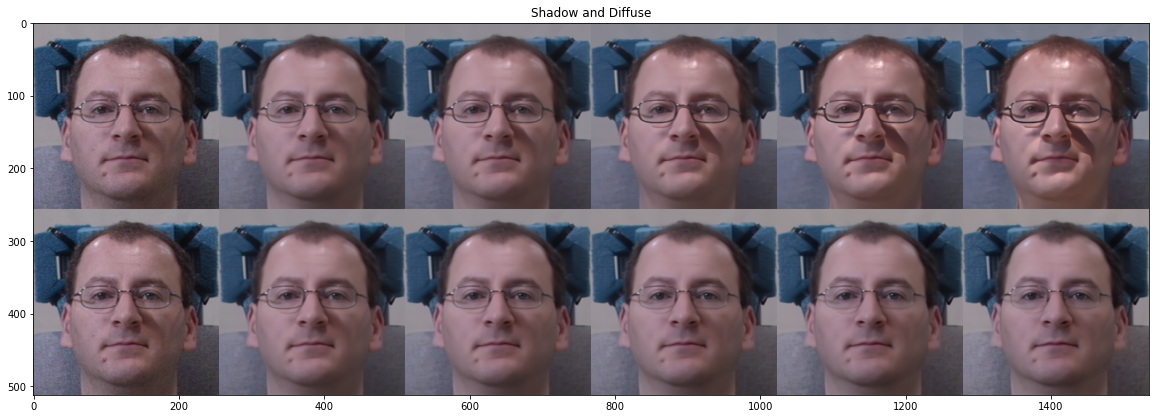

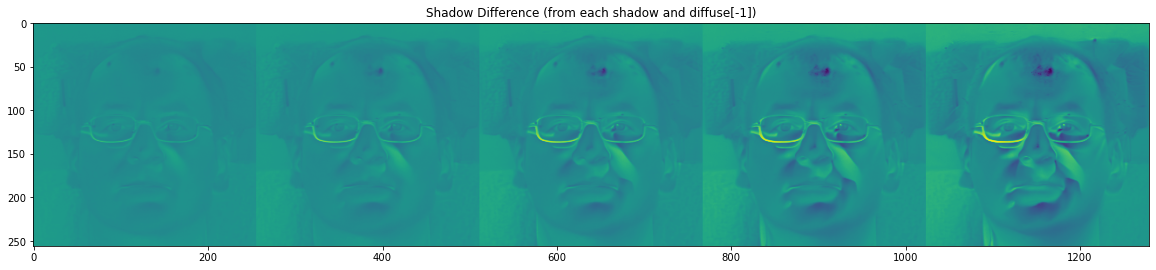

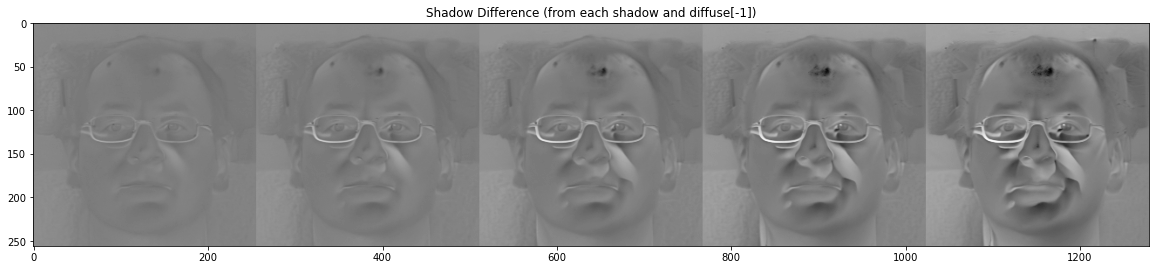

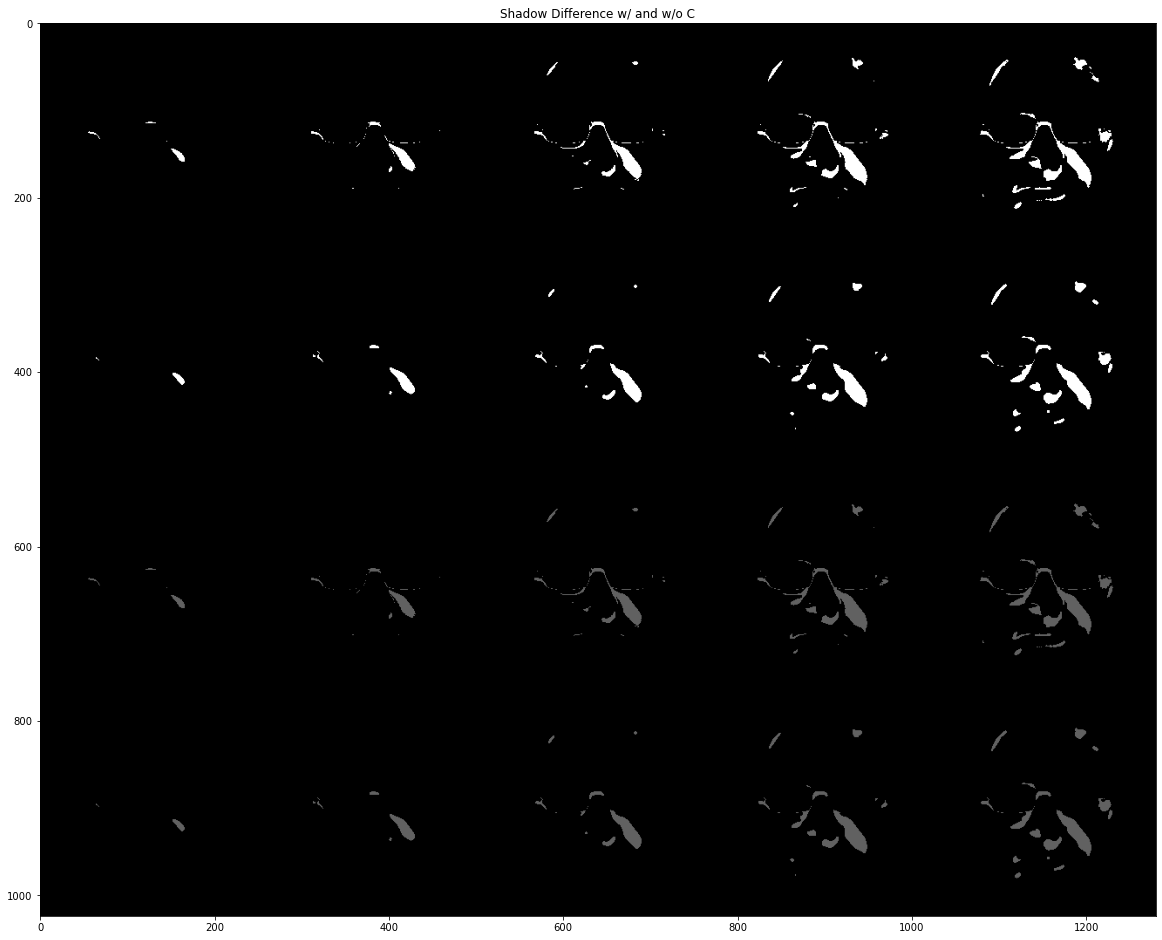

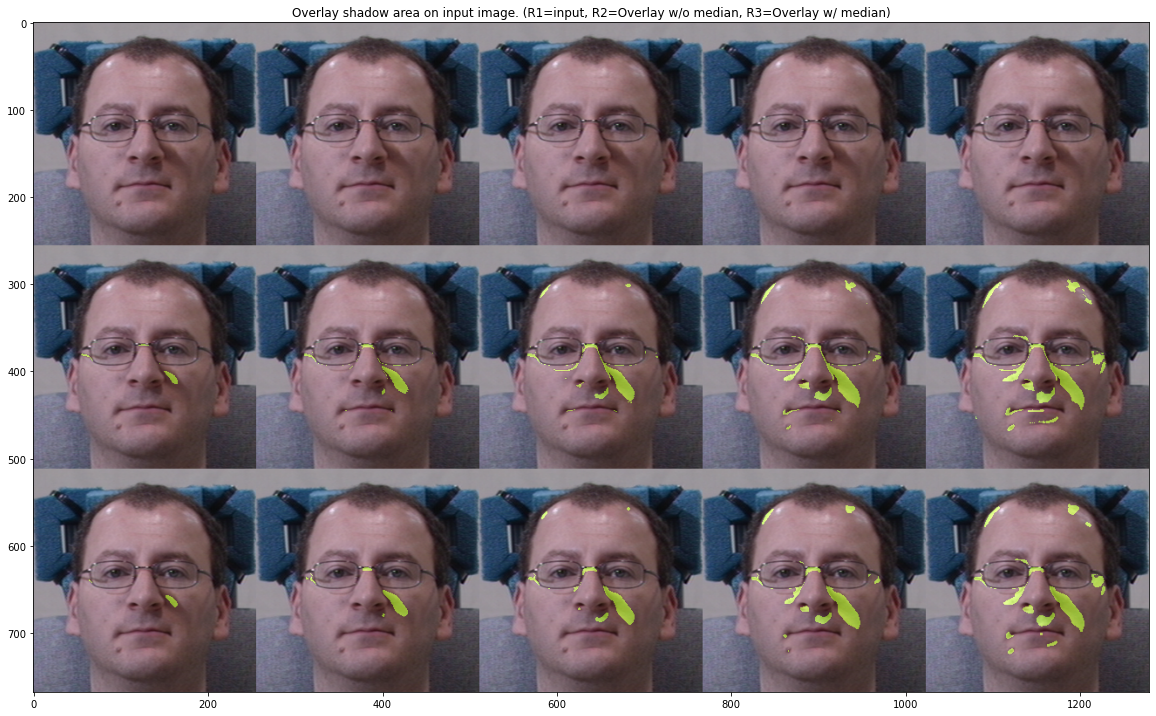

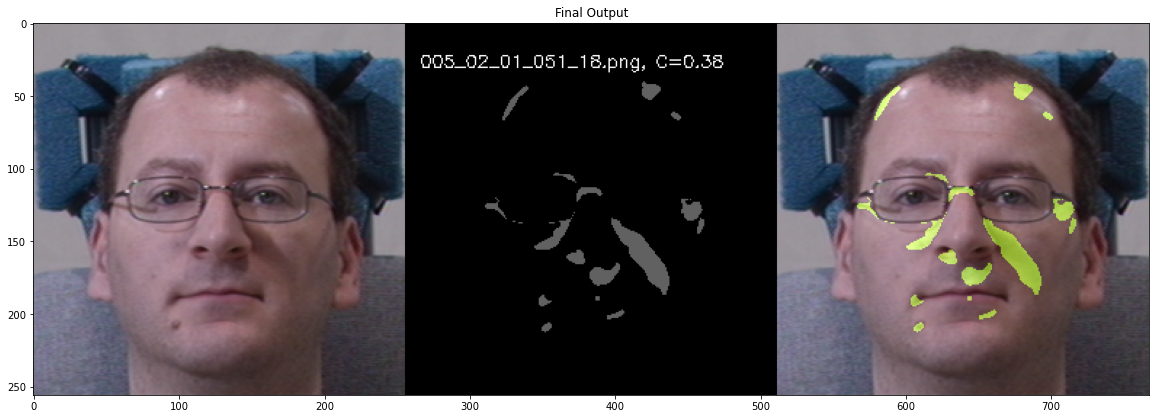

100%|██████████| 593/593 [01:10<00:00,  8.45it/s]


In [18]:
import glob
def process_smooth_shadow_diff(p_dict, img_name, 
                               shadow_idx, diffuse_idx,
                               save_vis=False, save_vis_path=None,
                               save_sd=False, save_sd_path=None, verbose=False,
                               ):
    # Save shape = (256, 256, 1), value = 0.0 to 1.0
    shadow = [Image.open(p_dict['shadow'] + f'/res_frame{i}.png') for i in range(n_frames_shadow)]
    diffuse = [Image.open(p_dict['diffuse'] + f'/res_frame{i}.png') for i in range(n_frames_diffuse)]
    face = Image.open(f'{image_path}/{img_name}')
    
    # Mask
    mask_image = Image.open(f'{mask_path}/anno_{img_name}')
    m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
    # m_glasses_and_eyes = face_segment('faceseg_eyes&glasses&mouth&eyebrows', mask_image)
    exclude = face_segment('faceseg_eyes&glasses&mouth&eyebrows', mask_image)
    
    # Shadow value (C)
    import pandas as pd
    max_c = 8.481700287326827 # 7.383497233314015
    min_c = -4.989461058405101 # -4.985533880236826
    c_p = f'{data_path}/params/{set_}/ffhq-{set_}-shadow-anno.txt'
    c = pd.read_csv(c_p, sep=' ', header=None, names=['image_name', 'c_val'])
    c_val = c[c['image_name'] == img_name]['c_val'].values[0]
    c_val_norm = (c_val - min_c)/(max_c - min_c)

    if verbose:
        print("[#] Shadow value : ", c_val, c_val_norm)
    
    s_grid = create_image_grid([face] + shadow, n_rows=1)
    d_grid = create_image_grid([face] + diffuse, n_rows=1)
    # print(s_grid.shape, d_grid.shape)
    if s_grid.shape[1] != d_grid.shape[1]:
        # Padding to the max
        to_pad = np.abs(s_grid.shape[1] - d_grid.shape[1])
        if s_grid.shape[1] > d_grid.shape[1]:
            d_grid = np.pad(d_grid, ((0, 0), (0, to_pad), (0, 0)), mode='constant', constant_values=0)
        else:
            s_grid = np.pad(s_grid, ((0, 0), (0, to_pad), (0, 0)), mode='constant', constant_values=0)
    
    c_type = 'L'
    shadow_diff_list = [get_shadow_diff(img1=shadow[i], img2=diffuse[diffuse_idx], c_type=c_type, signed=True) for i in range(n_frames_shadow)]
    if verbose:
        plt.imshow(np.concatenate((s_grid, d_grid), axis=0))
        plt.title("Shadow and Diffuse")
        plt.show()
        
        plt.imshow(create_image_grid(shadow_diff_list, n_rows=1))
        plt.title("Shadow Difference (from each shadow and diffuse[-1])")
        plt.show()
    
    thres = 0.05
    out = [
        (shadow_diff_list[0] < thres).astype(np.float32),
        (shadow_diff_list[1] < thres).astype(np.float32),
        (shadow_diff_list[2] < thres).astype(np.float32),
        (shadow_diff_list[3] < thres).astype(np.float32),
        (shadow_diff_list[4] < thres).astype(np.float32),
        cv2.medianBlur(((shadow_diff_list[0] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[1] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[2] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[3] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[4] < thres).astype(np.uint8)), 5),
    ]
    out = [np.abs(1 - (t)) for t in out] # Invert the mask
    # out = [((t * ~m_glasses_and_eyes) + (0.0 * m_glasses_and_eyes))  for t in out] # Ensure glasses area always 1
    out = [((t * ~exclude) + (0.0 * exclude))  for t in out] # Ensure glasses area always 1
    out = [((t * m_face)) for t in out] # Ensure outer face area always 0.5
    
    out_W = [t * c_val_norm for t in out] # For each shadow area, assign shadow value
    
    out_hl = [np.repeat((t[..., None]*255).astype(np.uint8), 3, axis=2) for t in out.copy()]
    out_hl = [cv2.applyColorMap(t, cv2.COLORMAP_WINTER) * (t==255) for t in out_hl]
    overlay_img = [cv2.addWeighted(np.array(face), 1, t, 0.5, 0) for t in out_hl]

    if verbose:
        plt.imshow(create_image_grid(shadow_diff_list, n_rows=1), cmap='gray')
        plt.title("Shadow Difference (from each shadow and diffuse[-1])")
        plt.show()
        
        shadow_mask = out + out_W
        plt.imshow(create_image_grid(shadow_mask, n_rows=4), cmap='gray')
        plt.title("Shadow Difference w/ and w/o C")
        plt.show()
        
        change = [face] * 5 + overlay_img
        plt.imshow(create_image_grid(change, n_rows=3))
        plt.title("Overlay shadow area on input image. (R1=input, R2=Overlay w/o median, R3=Overlay w/ median)")
        plt.show()
    
    vis_out_W = (np.repeat(out_W[shadow_idx][..., None], 3, axis=2) * 255.0).astype(np.uint8)
    cv2.putText(vis_out_W, f"{img_name}, C={c_val_norm:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    # print(np.min(vis_out_W), np.max(vis_out_W), np.unique(vis_out_W))
    # print(np.min(face), np.max(face))
    # print(np.min(overlay_img[-1]), np.max(overlay_img[-1]))

    if verbose:
        final_out = [np.array(face)] + [vis_out_W] + [overlay_img[shadow_idx]]
        final_out = create_image_grid(final_out, n_rows=1)
        plt.imshow(final_out)
        plt.title("Final Output")
        plt.show()
    
    if save_vis:
        if save_vis_path is None:
            assert False, "[#] Save path is not provided!"
        final_out = [np.array(face)] + [vis_out_W] + [overlay_img[-1]]
        final_out = create_image_grid(final_out, n_rows=1)
        Image.fromarray(final_out).save(f'{save_vis_path}/{img_name}.png')
        # print(final_out.shape)
        # plt.imshow(final_out)
        # plt.savefig(f'{save_vis_path}/{img_name}.png')

    if save_sd:
        if save_sd_path is None:
            assert False, "[#] Save path is not provided!"
        final_out_sd_w = out_W[shadow_idx][..., None]
        assert final_out_sd_w.shape == (256, 256, 1)
        assert np.min(final_out_sd_w) >= 0.0 and np.max(final_out_sd_w) <= 1.0
        # print(final_out_sd_w.shape, np.unique(final_out_sd_w))
        # assert False
        np.save(f"{save_sd_path}/{img_name.replace('.png', '')}.npy", final_out_sd_w)


shadow_idx = -1
diffuse_idx = -1
img_id = list(out_dict.keys())[0] 
process_smooth_shadow_diff(p_dict = out_dict[img_id], img_name=img_id, shadow_idx=-1, diffuse_idx=-1, verbose=True)
save_sd_path = f'/data/mint/DPM_Dataset/MultiPIE/{data_subf}/shadow_diff_SS_with_c_simplified/{set_}/'
save_vis_path = f'/data/mint/DPM_Dataset/MultiPIE/{data_subf}/shadow_diff_SS_with_c_simplified/vis/{set_}/'
os.makedirs(save_sd_path, exist_ok=True)
os.makedirs(save_vis_path, exist_ok=True)
# assert False

for k in tqdm.tqdm(out_dict.keys()):
    process_smooth_shadow_diff(p_dict = out_dict[k], img_name=k, 
                               save_vis=True, save_sd=True, 
                               save_sd_path=save_sd_path, save_vis_path=save_vis_path, verbose=False,
                               shadow_idx=shadow_idx, diffuse_idx=diffuse_idx)